## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [2]:
import pandas as pd
from collections import Counter
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant as ac
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,  mean_squared_error, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Test
dfp = pd.read_csv('US_Heart_Patients.csv')
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
dfp.shape

(4240, 16)

In [5]:
target_var = 'TenYearCHD'

In [6]:
dfp.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0
education,4135.0,1.979444,1.019791,1.00,1.00,2.0,3.00,4.0
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0


In [7]:
def cm_data(cm):
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    print("Sensitivity: ", tp/(tp+fn))
    print("Specificity: ",tn/(tn+fp))
    print("Precision: ", tp/(tp+fp))
    print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))

In [8]:
def check_accuracy(test, pred, conf_mat = 'no'):
    acc = accuracy_score(test, pred)
    if conf_mat == 'yes':
        cm = confusion_matrix(test, pred)
        cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])
        # plt.figure(figsize=(10, 10))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.show()
        cm_data(cm)
    return acc
    

In [9]:
# # After the above function has run this function would be called and it would 
# # print all accuracies along with the best one.

# def print_best(name, x):
#     print("No Sampling Done  :", x['not'])
#     print("Over              :", x['o'])
#     print("Under             :", x['u'])
#     print("Both              :", x['b'])

#     code = {
#         'not': 'No Sampling Done',
#         'o': 'SMOTE',
#         'u': 'NearMiss',
#         'b': 'SMOTE and Then NearMiss'
#     }
#     print("\nBest way in {} model is:".format(str(name)[:-2]), code[max(zip(x.values(), x.keys()))[1]])

In [10]:
# # Purpose of the function is to determine which balancing technique is working the best.
# # If we find one we would then rerun the function with that accuracy.

# def all_samp_acc(model, params, df, cm = 'no'):

#     if cm == 'yes':
#         print("No Sampling: ")        
#     _, no_samp_acc = rand_search(model = model, params = params, df = df, encod = 'd', cm=cm)
    
#     if cm == 'yes':
#         print("SMOTE: ")
#     _, over_samp_acc = rand_search(model = model, params = params, df = df, samp = 'o', encod = 'd', cm=cm)
    
#     if cm == 'yes':
#         print("NearMiss: ")
#     _, under_samp_acc = rand_search(model = model, params = params, df = df, samp = 'u', encod = 'd', cm=cm)
    
#     if cm == 'yes':
#         print("Both: ")
#     _, both_samp_acc = rand_search(model = model, params = params, df = df, samp = 'b', encod = 'd', cm=cm)
    
#     acc = {
#     'not': no_samp_acc,
#     'o': over_samp_acc,
#     'u': under_samp_acc,
#     'b': both_samp_acc
#     }
#     print_best(model, acc)  

In [11]:
# Check Multicollinearilty

def check_multicol(x):
    plt.figure(figsize=(20, 10))
    sns.heatmap(x.corr(), annot=True)
    plt.show()

In [12]:
# Implementing SMOTE

def smote(x, y):
    oversample = SMOTE(random_state = 2, sampling_strategy='minority')
    x = x.values
    y = y.values
    x, y = oversample.fit_resample(x, y)
    return x, y

In [13]:
# Implementing NearMiss

def near_miss(x, y):
    nr = NearMiss() 
    x_near, y_near= nr.fit_resample(x, y)
    return x_near, y_near

In [14]:
def rand_search(model, params, df, encod = 'd', samp = None, cm = 'no'):

    x = df.loc[:, df.columns != target_var]
    y = df.loc[:, target_var]

    # if encod == 'l':
    #     x = x.apply(LabelEncoder().fit_transform)
    #     x = x.apply(LabelEncoder().transform)
    # else:
    #     x = pd.get_dummies(x, drop_first=True)
    #     x = pd.get_dummies(x, drop_first=True)
    
    if samp != None:
        if samp == 'o':
            x, y = smote(x, y)
        elif samp == 'u':
            x, y = near_miss(x, y)
        elif samp == 'b':
            x, y = smote(x, y)
            x, y = near_miss(x, y)
    
    x = pd.DataFrame(x)
    y = pd.DataFrame(y, columns=['TenYearCHD'])
    
    x_train, x_test, y_train, y_test = split_data(pd.concat([x, y], axis=1))

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    grid_mod = RandomizedSearchCV(model, param_distributions=params, scoring = ['accuracy', 'f1'], cv = 10, n_jobs=-1, refit='accuracy')
    
    grid_mod.fit(x_train, y_train)

    y_pred = grid_mod.predict(x_test)

    if cm == 'yes':
        acc = check_accuracy(y_test, y_pred, conf_mat = 'yes')

    return grid_mod.best_estimator_, acc

In [15]:
def split_data(df, y = target_var, val = 'no'):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]
    
    x_train, x_val, y_train, y_val =  train_test_split(x, y, test_size = 0.2, random_state = 123)
    return x_train, x_val, y_train, y_val 

###  EDA and Feature Engineering

#### Univariate Analysis

In [16]:
# Caonverting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
dfp[to_be_cat]= dfp[to_be_cat].astype('category')
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [17]:
not_to_plot = [] # contains column names which are not to be plotted. In this case we have none.
rand_color = ['red', 'blue', 'green']

In [18]:
def univariate(df, rows = 4, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        ax=fig.add_subplot(rows,cols,j+1)
        if i in df.select_dtypes(['category']):
            sns.countplot(x= i, data = df, ax=ax)
        if i in df.select_dtypes(['int', 'float64']):
            sns.distplot(x = df[i], ax=ax, color=np.random.choice(rand_color))
    fig.tight_layout() 
    plt.show()

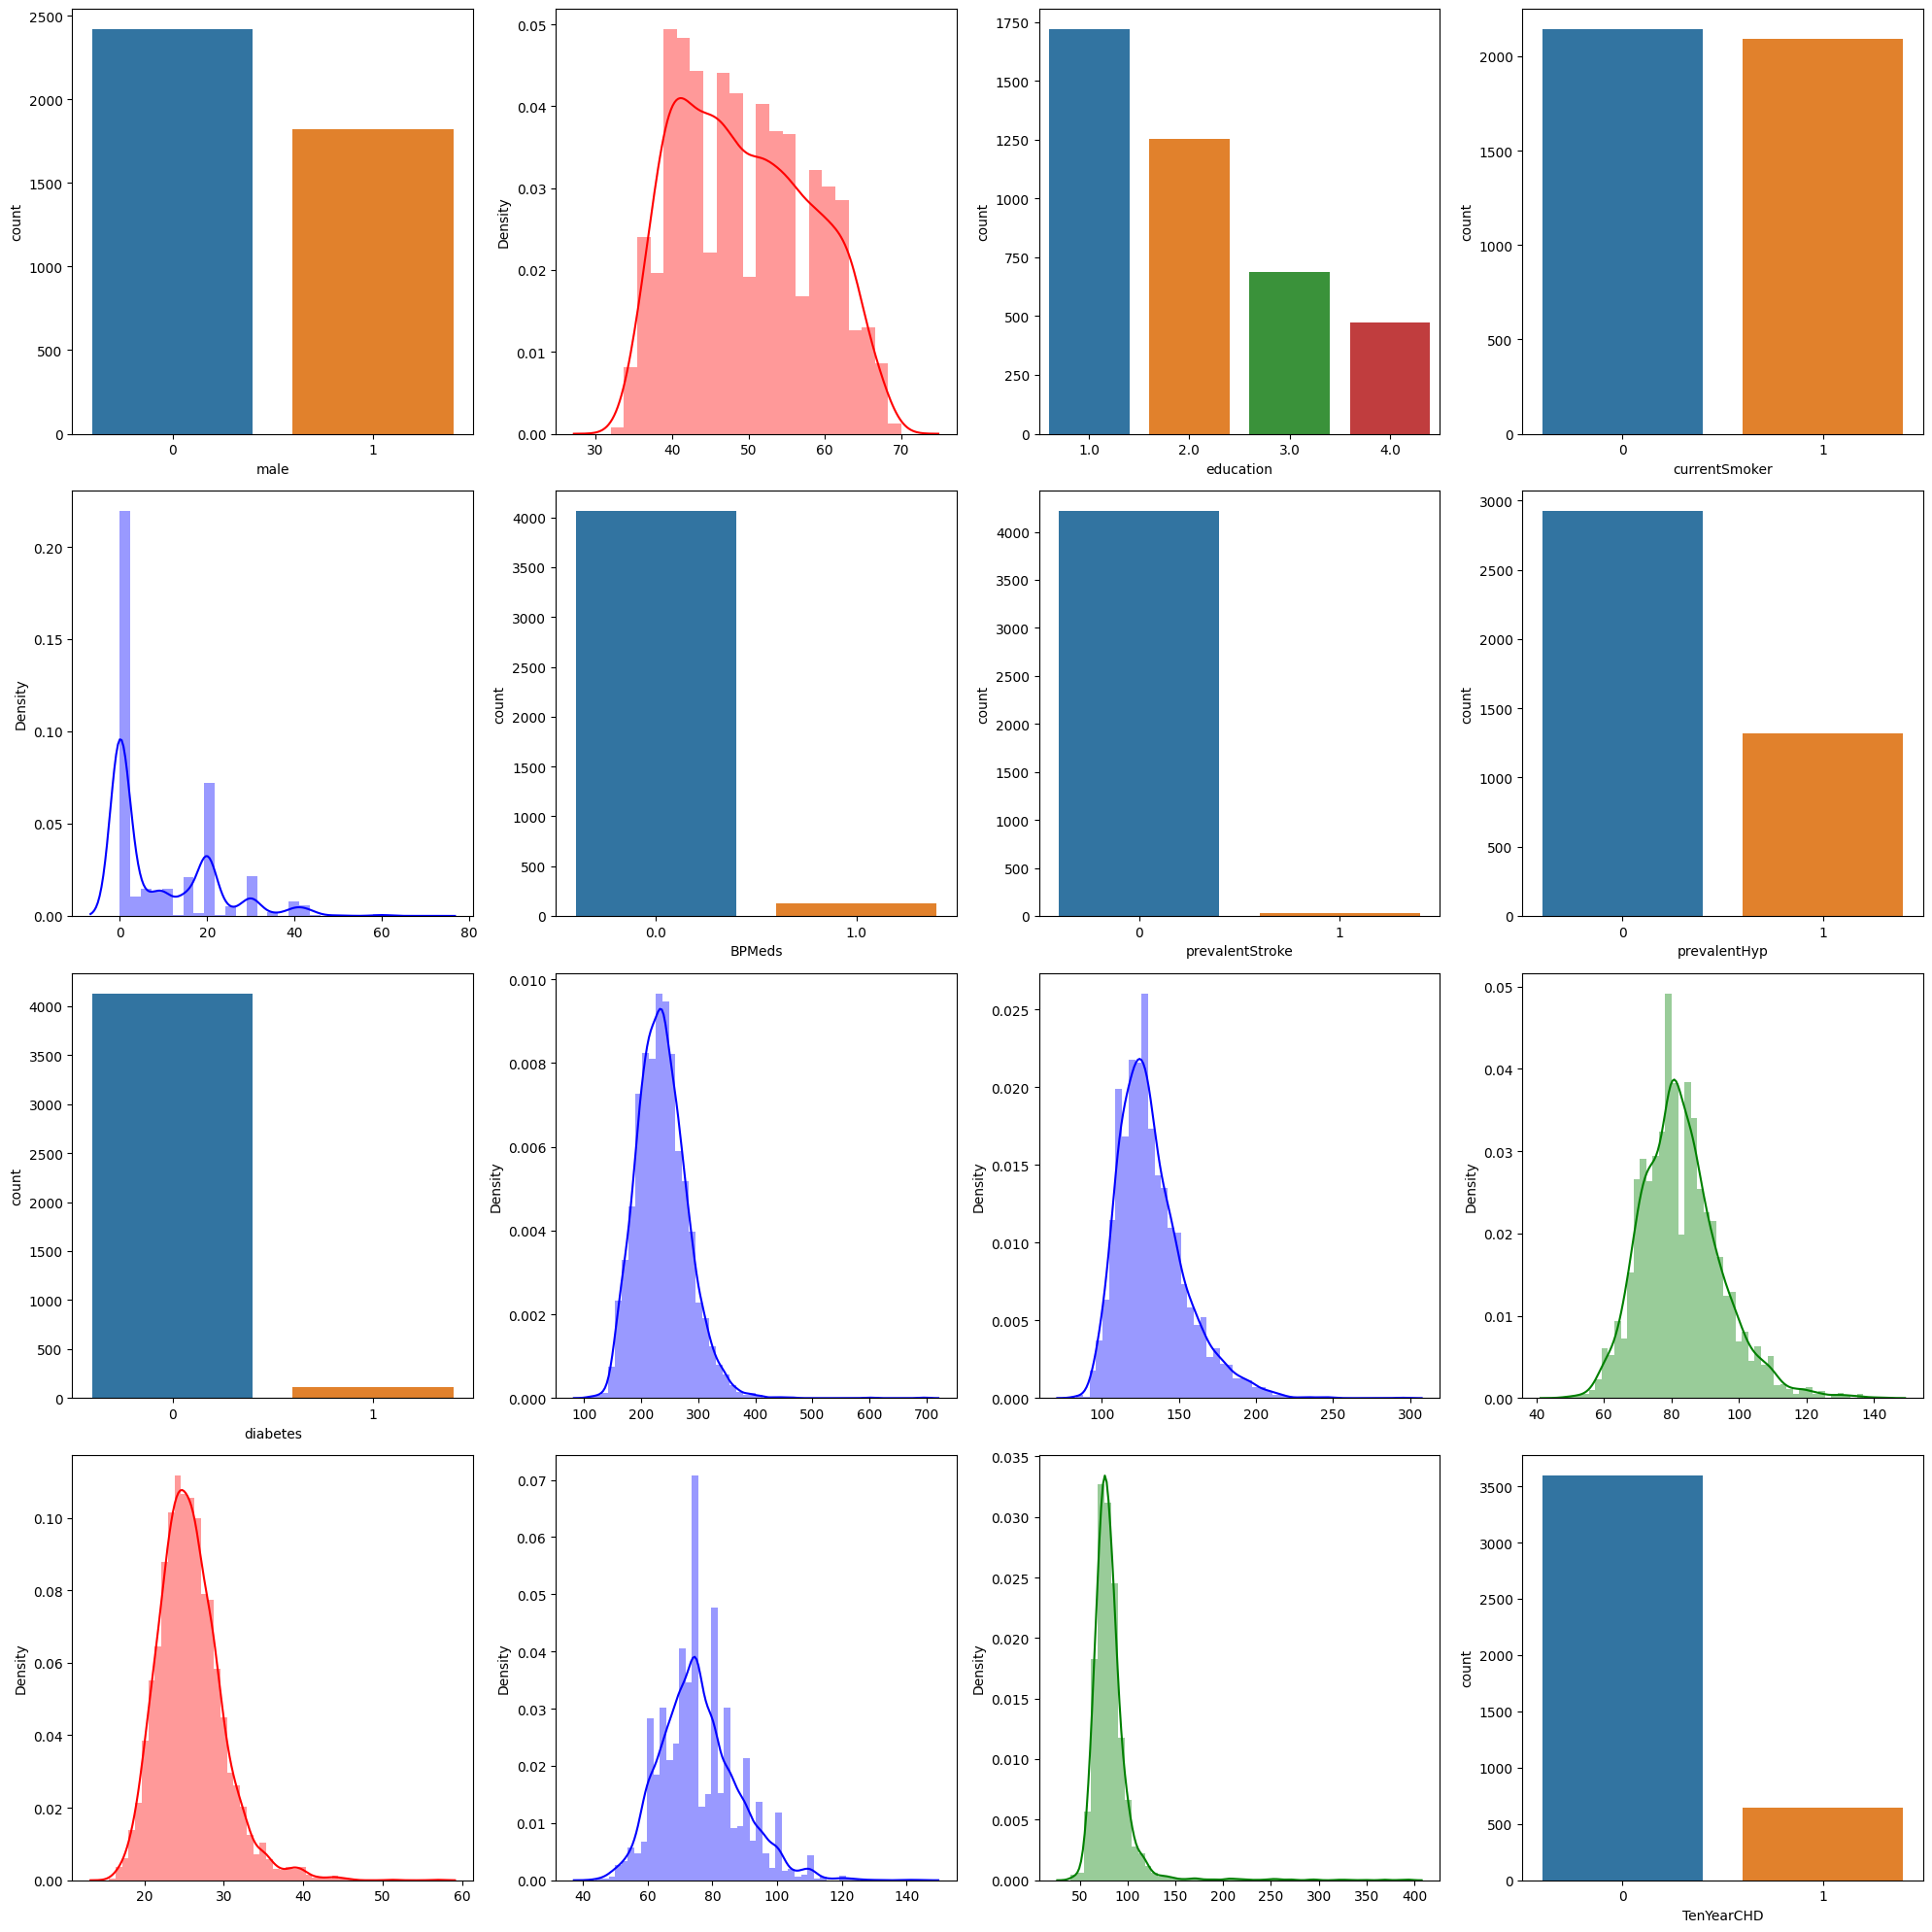

In [19]:
univariate(dfp)

#### Bivariate Analysis

In [20]:
def bivariate(df = dfp, y = target_var, cols = 4, rows = 4):
    temp = not_to_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if df[y].dtype == 'float':
            if i in df.select_dtypes(['category']):
                if (i not in temp): 
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = i, y = y, data = df)

            if i in df.select_dtypes(['float', 'int']):                
                if (i not in temp):      
                    ax=fig.add_subplot(rows,cols,j+1)       
                    sns.scatterplot(x = y, y = i, data = df)                  
            
        elif df[y].dtype == 'category':
            if i in df.select_dtypes(['category']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.countplot(x = i, hue = y, data = df)
                    plt.legend(bbox_to_anchor=(1, 1), loc=2, labels=['Not Survived', 'Survived'], borderaxespad=0.)

            if i in df.select_dtypes(['float', 'int']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

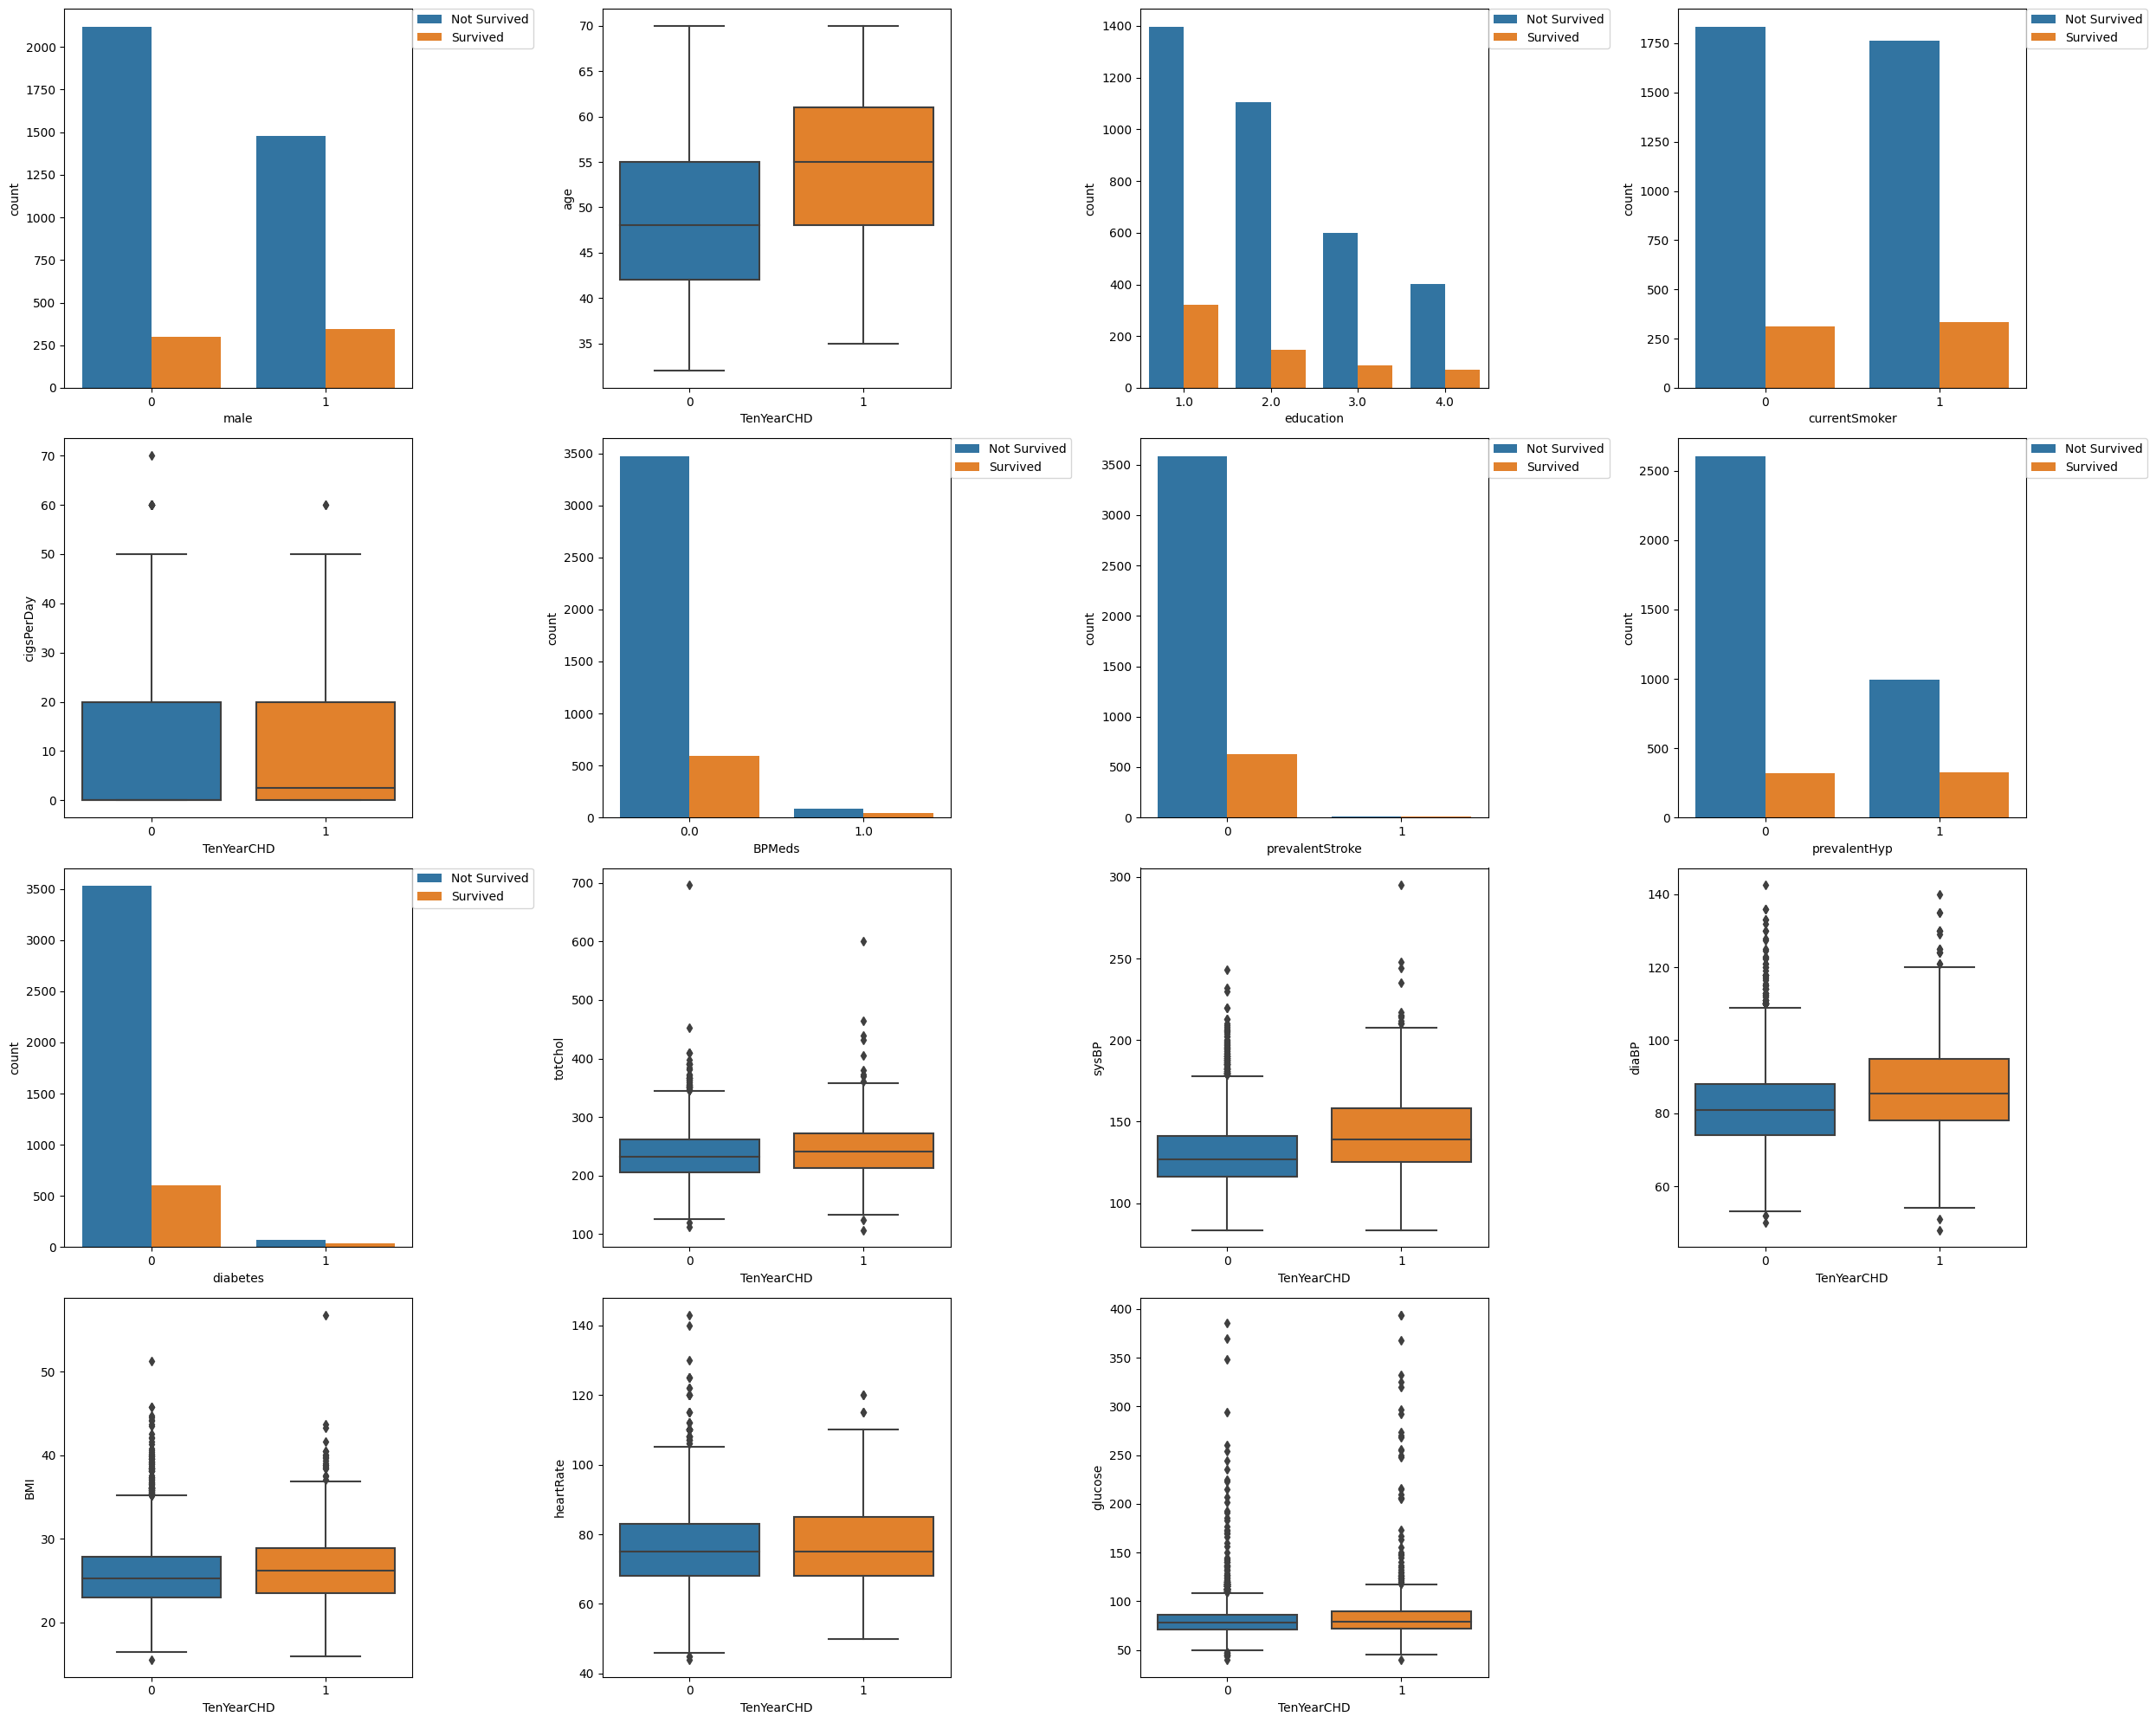

In [21]:
bivariate()

#### Missing Values

In [22]:
dfp.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [23]:
# % of all missing var
miss_df = pd.DataFrame(dfp.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/dfp.shape[0])
        

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [24]:
dfp.drop(['education', 'glucose'], axis = 1, inplace = True)

In [25]:
dfp.isnull().sum()

male                0
age                 0
currentSmoker       0
cigsPerDay         29
BPMeds             53
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol            50
sysBP               0
diaBP               0
BMI                19
heartRate           1
TenYearCHD          0
dtype: int64

In [26]:
# Case 1: Drop All Null Values.
dfp.dropna(inplace=True)
dfp.isnull().sum()

male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
TenYearCHD         0
dtype: int64

In [27]:
dfp.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,0


In [28]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 0 to 4239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4090 non-null   category
 1   age              4090 non-null   int64   
 2   currentSmoker    4090 non-null   category
 3   cigsPerDay       4090 non-null   float64 
 4   BPMeds           4090 non-null   category
 5   prevalentStroke  4090 non-null   category
 6   prevalentHyp     4090 non-null   category
 7   diabetes         4090 non-null   category
 8   totChol          4090 non-null   float64 
 9   sysBP            4090 non-null   float64 
 10  diaBP            4090 non-null   float64 
 11  BMI              4090 non-null   float64 
 12  heartRate        4090 non-null   float64 
 13  TenYearCHD       4090 non-null   category
dtypes: category(7), float64(6), int64(1)
memory usage: 284.4 KB


#### Model Building

##### 1. Logistic Regression

In [29]:
x = dfp.loc[:, dfp.columns != target_var]
y = dfp.loc[:, target_var]

x = x.apply(LabelEncoder().fit_transform)

model = sm.Logit(y, ac(x))
res = model.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.375018
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 4090
Model:                          Logit   Df Residuals:                     4076
Method:                           MLE   Df Model:                           13
Date:                Fri, 07 Oct 2022   Pseudo R-squ.:                  0.1106
Time:                        17:39:33   Log-Likelihood:                -1533.8
converged:                       True   LL-Null:                       -1724.5
Covariance Type:            nonrobust   LLR p-value:                 1.863e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.4643      0.261    -17.099      0.000      -4.976      -3.953
male          

In [30]:
# Removing cols with p-value more than 0.05

def back_feat_elem(df = dfp, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x = x.apply(LabelEncoder().fit_transform)

    col = x.columns

    while len(col) > 0:
        model = sm.Logit(y, ac(x[col]))
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            col = col.drop(largest_pvalue.index)  

In [31]:
back_res = back_feat_elem()
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4090
Model:                          Logit   Df Residuals:                     4084
Method:                           MLE   Df Model:                            5
Date:                Fri, 07 Oct 2022   Pseudo R-squ.:                  0.1080
Time:                        17:39:33   Log-Likelihood:                -1538.3
converged:                       True   LL-Null:                       -1724.5
Covariance Type:            nonrobust   LLR p-value:                 2.451e-78
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4335      0.172    -25.711      0.000      -4.771      -4.096
male           0.5164      0.099      5.197      0.000       0.322       0.711
age            0.0678      0.006     11.111      0.000       0.056       0.080
cigsPerDay     0.0281      0.005      5.609      0.000       0.018       0.038
diabetes       0.7152      0.223      3.204      0.001       0.278       1.153
sysBP          0.0094      0.001      8.679      0.000       0.007       0.012
==============================================================================
"""

In [32]:
ind = list(back_res.params.index)
ind.remove('const')
# To Insert Imp Cols that I like.
# ind.extend([''])
ind

['male', 'age', 'cigsPerDay', 'diabetes', 'sysBP']

In [33]:
new_x = dfp[ind]
new_y = dfp.TenYearCHD
new_df = pd.concat([new_x,new_y], axis=1)
new_df.head()

,male,age,cigsPerDay,diabetes,sysBP,TenYearCHD
0,1,39,0.0,0,106.0,0
1,0,46,0.0,0,121.0,0
2,1,48,20.0,0,127.5,0
3,0,61,30.0,0,150.0,1
4,0,46,23.0,0,130.0,0


In [34]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

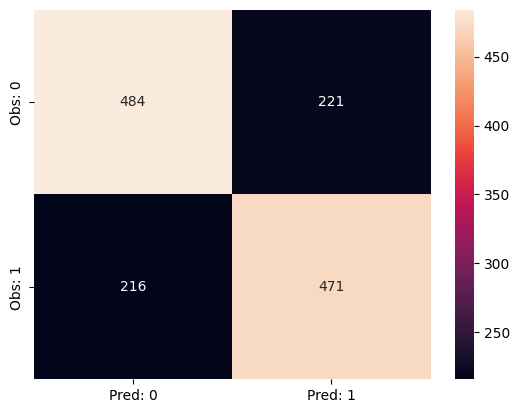

Sensitivity:  0.6855895196506551
Specificity:  0.6865248226950355
Precision:  0.680635838150289
Accuracy:  0.6860632183908046


In [35]:
mod_lg_o, acc_lg_o = rand_search(model = LogisticRegression(), params =  params_lg, samp='o', df = dfp, cm='yes')

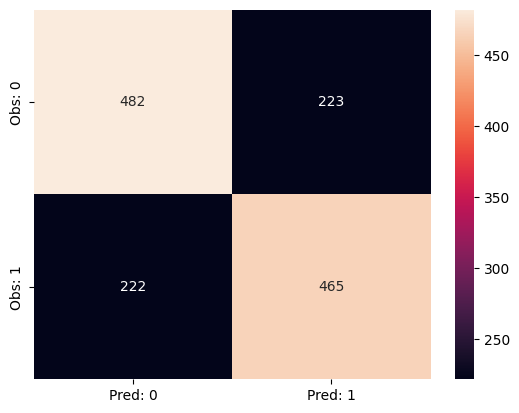

Sensitivity:  0.6768558951965066
Specificity:  0.6836879432624113
Precision:  0.6758720930232558
Accuracy:  0.680316091954023


In [36]:
mod_lg_n, acc_lg_n = rand_search(model = LogisticRegression(), params =  params_lg, samp='o', df = new_df, cm='yes')

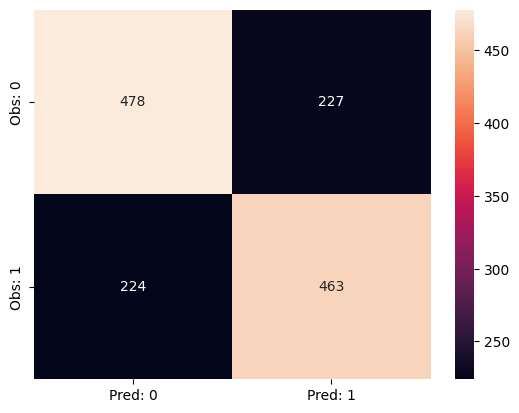

Sensitivity:  0.6739446870451238
Specificity:  0.6780141843971631
Precision:  0.6710144927536232
Accuracy:  0.6760057471264368


In [37]:
mod_lg_n1, acc_lg_n1 = rand_search(model = LogisticRegression(), params =  params_lg, samp='o', df = new_df, cm='yes')

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

In [38]:
new_df.TenYearCHD = new_df.TenYearCHD.astype('category')
new_df.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [39]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

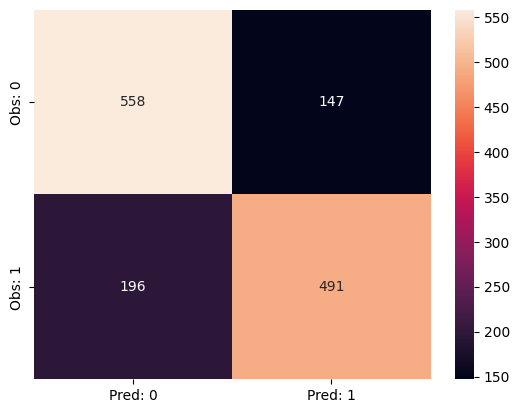

Sensitivity:  0.7147016011644832
Specificity:  0.7914893617021277
Precision:  0.7695924764890282
Accuracy:  0.7535919540229885


In [40]:
mod_dt_o, acc_dt_o = rand_search(model = DecisionTreeClassifier(), params = params_dt, samp = 'o', df = dfp, cm='yes')

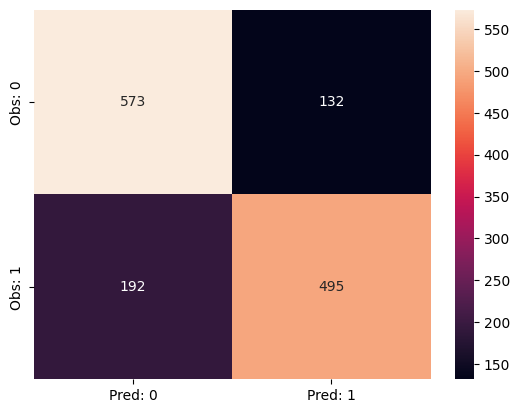

Sensitivity:  0.7205240174672489
Specificity:  0.8127659574468085
Precision:  0.7894736842105263
Accuracy:  0.7672413793103449


In [41]:
mod_dt_n, acc_dt_n = rand_search(model = DecisionTreeClassifier(), params = params_dt, df = new_df, samp = 'o', cm='yes')

##### 3: KNN Classification

In [42]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
    'p':[0,1,2,i]
}

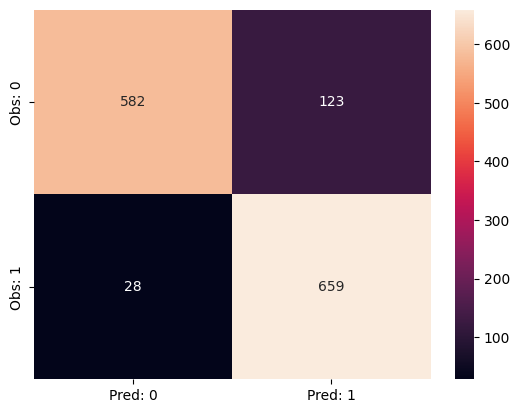

Sensitivity:  0.9592430858806404
Specificity:  0.825531914893617
Precision:  0.8427109974424553
Accuracy:  0.8915229885057471


In [43]:
mod_knn_o, acc_knn_o = rand_search(model = KNeighborsClassifier(), params = params_knn, df = dfp, cm='yes', samp = 'o')

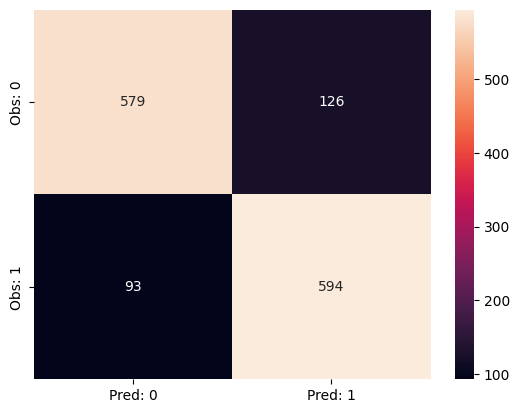

Sensitivity:  0.8646288209606987
Specificity:  0.8212765957446808
Precision:  0.825
Accuracy:  0.8426724137931034


In [44]:
mod_knn_n, acc_knn_n = rand_search(model = KNeighborsClassifier(), params = params_knn, df = new_df, cm='yes', samp = 'o')

##### 4: SVC

In [45]:
params_svc = {
    'C': [0.1, 1, 10, 15, 20],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo','ovr']
}

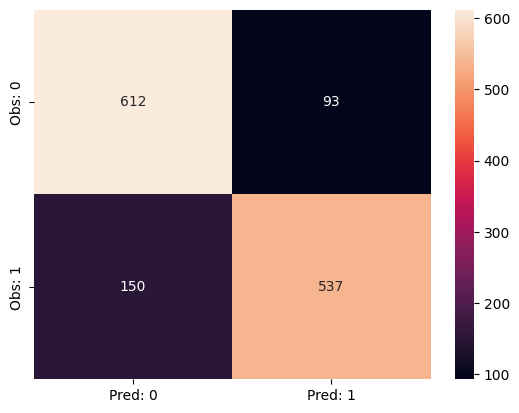

Sensitivity:  0.7816593886462883
Specificity:  0.8680851063829788
Precision:  0.8523809523809524
Accuracy:  0.8254310344827587


In [46]:
mod_svc_o, svc_acc_o = rand_search(model = SVC(), params = params_svc, samp = 'o', df = dfp, encod= 'd', cm='yes')

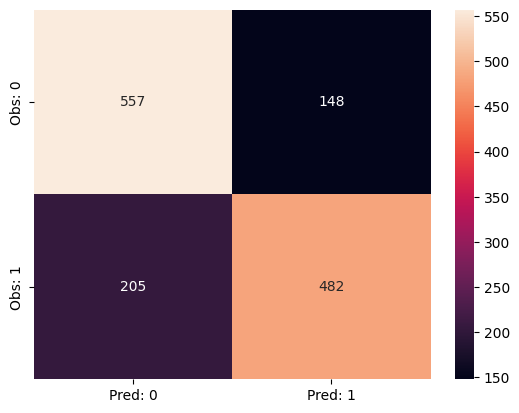

Sensitivity:  0.7016011644832606
Specificity:  0.7900709219858156
Precision:  0.765079365079365
Accuracy:  0.7464080459770115


In [47]:
mod_svc_n, svc_acc_n = rand_search(model = SVC(), params = params_svc, samp = 'o', df = new_df, encod= 'd', cm='yes')

##### 5: Neural Networks

In [48]:
# To be done in the future

##### 6: Complex SVM

In [49]:
# To be done in the future

##### 7: Complex Neural Networks 

In [50]:
# To be done in the future

##### 8: Random Forest Classifier

Using GridSearchCV for Random Forest Classifier

In [51]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
    'n_jobs': [3],
}

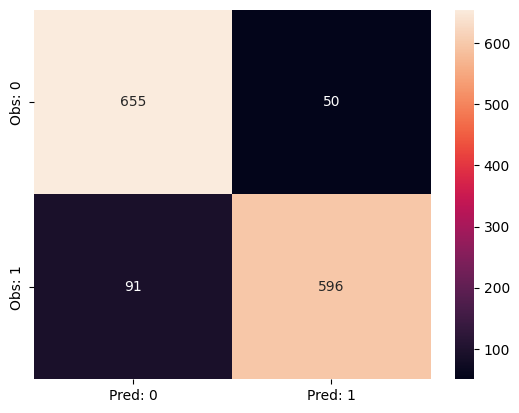

Sensitivity:  0.8675400291120815
Specificity:  0.9290780141843972
Precision:  0.9226006191950464
Accuracy:  0.8987068965517241


In [52]:
mod_rf_o, acc_rf_o = rand_search(model=RandomForestClassifier(), params=rf_params, df = dfp, samp='o', cm='yes')

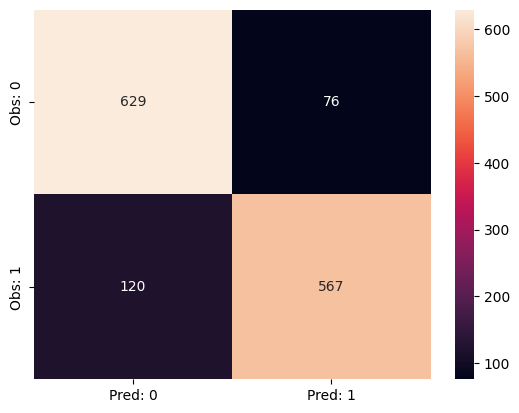

Sensitivity:  0.8253275109170306
Specificity:  0.8921985815602836
Precision:  0.8818040435458787
Accuracy:  0.8591954022988506


In [53]:
mod_rf_n, acc_rf_n = rand_search(model=RandomForestClassifier(), params=rf_params, df = new_df, samp='o', cm='yes')

In Random Forest, the old DataFrame (dfp) is slightly better than the new one.

##### 9: BaggingClassifier

In [54]:
new_models = [mod_dt_n, mod_knn_n, mod_lg_n, mod_svc_n, mod_rf_n] # Models Trained on New Data
old_models = [mod_dt_o, mod_knn_o, mod_lg_o, mod_svc_o, mod_rf_o] # Models Trained on Old Data

In [55]:
params_bg_o = {
    'base_estimator': old_models,
    'n_estimators': [10, 20, 30, 40, 50],
    'n_jobs':[-1]
}

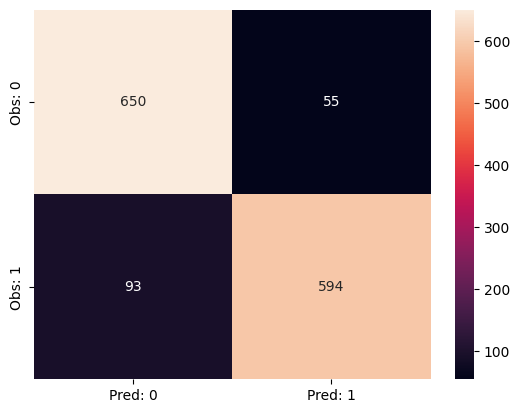

Sensitivity:  0.8646288209606987
Specificity:  0.9219858156028369
Precision:  0.9152542372881356
Accuracy:  0.8936781609195402


In [56]:
mod_bg_o, acc_bg_o = rand_search(model = BaggingClassifier(), params = params_bg_o, df = dfp, encod = 'd', cm='yes', samp = 'o')

In [57]:
params_bg_n = {
    'base_estimator': new_models,
    'n_estimators': [10, 20, 30, 40, 50],
    'n_jobs':[-1]
}

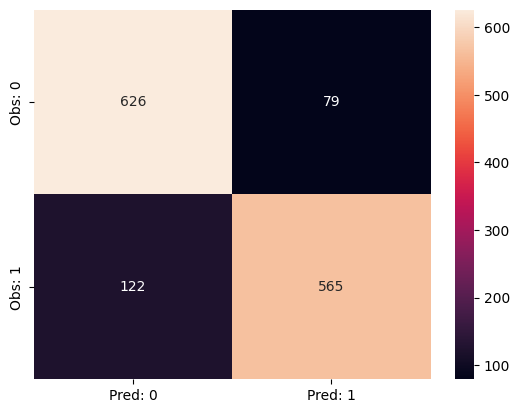

Sensitivity:  0.8224163027656477
Specificity:  0.8879432624113475
Precision:  0.8773291925465838
Accuracy:  0.8556034482758621


In [58]:
mod_bg_n, acc_bg_n = rand_search(model = BaggingClassifier(), params = params_bg_n, df = new_df, encod = 'd', cm='yes', samp='o')

##### 10: StackingClassifier

In [59]:
base_lv_n = []
for i in new_models:
    base_lv_n.append((str(i)[:2], i))
base_lv_n[0]

('De',
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5))

In [60]:
base_lv_o = []
for i in old_models:
    base_lv_o.append((str(i)[:2], i))
base_lv_o[0]

('De',
 DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features='sqrt',
                        min_samples_leaf=5))

In [61]:
params_sc = {
    'estimators': [base_lv_o, base_lv_n],
    'cv': [5, 10, 15]
}

In [62]:
# mod_sc, acc_sc = rand_search(model = StackingClassifier(estimators = base_lv_n), params = params_sc, cm = 'yes', df = dfp)

In [63]:
# x = dfp.loc[:, dfp.columns != target_var]  # type: ignore
# y = dfp.loc[:, target_var]

# x, y = smote(x, y)

# x = pd.DataFrame(x)
# y = pd.DataFrame(y, columns=['TenYearCHD'])

# df = pd.concat([x, y], axis=1)

# x_train, x_val, y_train, y_val = split_data(df)

# x_train = sc.fit_transform(x_train)
# x_val = sc.transform(x_val)
# # x_test = sc.transform(x_test)

# mod_sc = StackingClassifier(
#     estimators=base_lv_n, 
#     cv = 7, 
#     n_jobs=-1,
#     passthrough=True)

# mod_sc.fit(x_train, y_train)
# y_val_pred = mod_sc.predict(x_val)

# acc = check_accuracy(y_val, y_val_pred, conf_mat = 'yes')